In [1]:
from keras.datasets import cifar10
from keras.models import load_model
import keras.backend as K
import numpy as np
from six.moves import cPickle as pickle

from IPython import display
import matplotlib.pyplot as plt

% matplotlib inline
% config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
# Fetch data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert uint8 pixel values to float32 in the range [0, 1] (for sigmoid)
X_test = X_test.astype('float32')
X_test /= 255

acc_trend = []
epochs = range(10, 501, 10)
for epoch in epochs:
    all_class_preds = np.ndarray(shape=(X_test.shape[0], 10), dtype=np.float32)
    for image_class in range(10):
        discriminator = load_model("networks/disc" + str(image_class) + "-" + str(epoch) + ".h5")
        preds = discriminator.predict(X_test)
        class_preds = preds[:, 0]
        all_class_preds[:, image_class] = class_preds
    K.clear_session() # To avoid running out of memory
    
    # Calculate joint accuracy
    all_class_preds_index = np.argmax(all_class_preds, axis=1)
    accuracy = 0
    for y, p in zip(y_test, all_class_preds_index):
        if y == p:
            accuracy += 1
    accuracy /= 1. * len(y_test)
    acc_trend.append(accuracy)
    
    print "Epoch: {:d}, Joint Accuracy: {:.4f}".format(epoch, accuracy)

pickle.dump(acc_trend, open("regular-Mode2_acc.pickle", "wb" ))

Epoch: 10, Joint Accuracy: 0.6041
Epoch: 20, Joint Accuracy: 0.6875
Epoch: 30, Joint Accuracy: 0.7348
Epoch: 40, Joint Accuracy: 0.7625
Epoch: 50, Joint Accuracy: 0.7700
Epoch: 60, Joint Accuracy: 0.7757
Epoch: 70, Joint Accuracy: 0.7810
Epoch: 80, Joint Accuracy: 0.7839
Epoch: 90, Joint Accuracy: 0.7820
Epoch: 100, Joint Accuracy: 0.7899
Epoch: 110, Joint Accuracy: 0.7951
Epoch: 120, Joint Accuracy: 0.7955
Epoch: 130, Joint Accuracy: 0.7969
Epoch: 140, Joint Accuracy: 0.7977
Epoch: 150, Joint Accuracy: 0.7945
Epoch: 160, Joint Accuracy: 0.7969
Epoch: 170, Joint Accuracy: 0.7967
Epoch: 180, Joint Accuracy: 0.8005
Epoch: 190, Joint Accuracy: 0.8000
Epoch: 200, Joint Accuracy: 0.8012
Epoch: 210, Joint Accuracy: 0.7996
Epoch: 220, Joint Accuracy: 0.8031
Epoch: 230, Joint Accuracy: 0.8097
Epoch: 240, Joint Accuracy: 0.8043
Epoch: 250, Joint Accuracy: 0.8114
Epoch: 260, Joint Accuracy: 0.8072
Epoch: 270, Joint Accuracy: 0.8092
Epoch: 280, Joint Accuracy: 0.8037
Epoch: 290, Joint Accuracy: 0

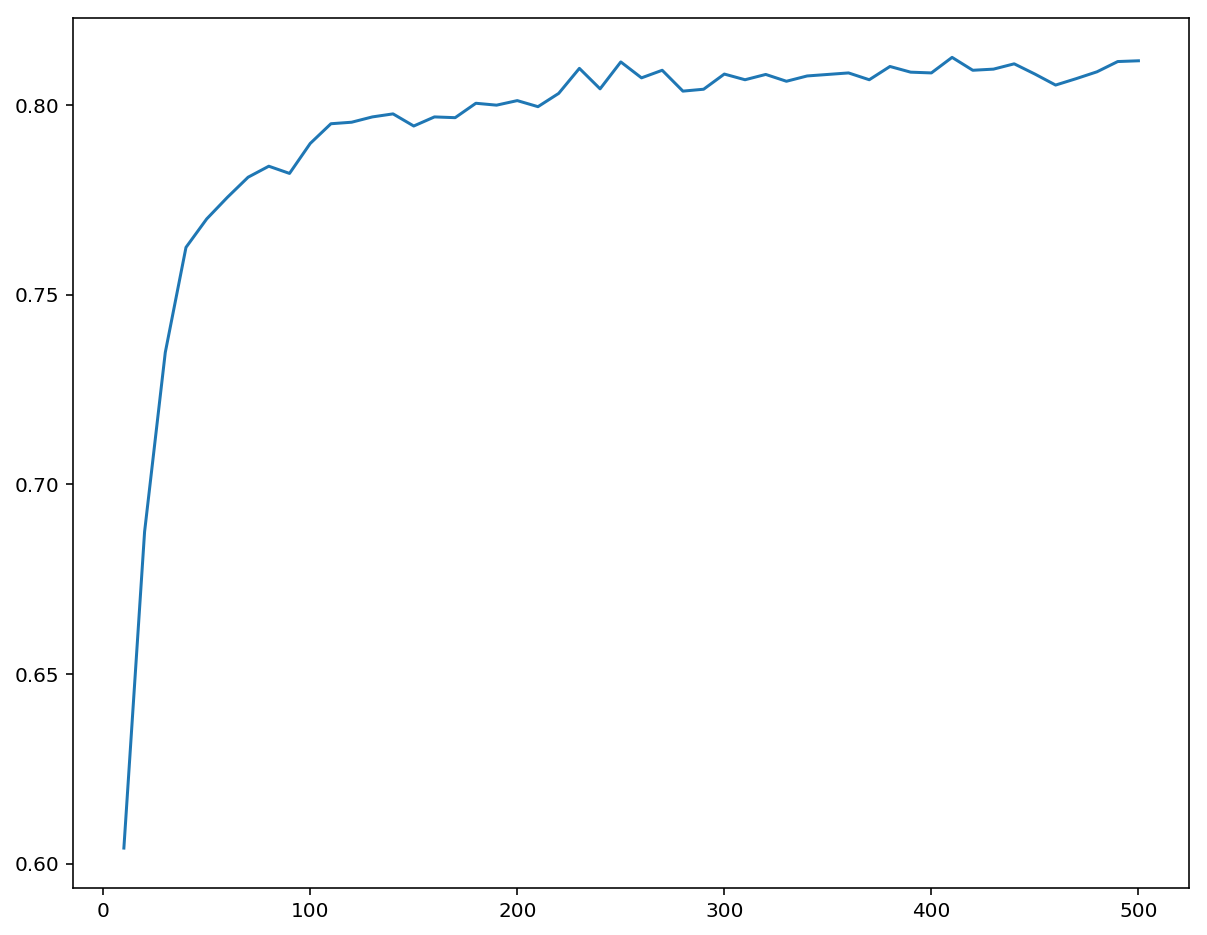

In [3]:
acc_trend = pickle.load(open("regular-Mode2_acc.pickle", "rb" ))
epochs = range(10, 501, 10)

plt.figure(figsize=(10,8))
plt.plot(epochs, acc_trend)
plt.show()